# Tugas Hands-On 3 Digital Signal Processing

NIM: 122140055

# Respiration - The Rhythm Beneath the Breath

## Optical Flow
Optical flow is the pattern of motion in a sequence of images or video frames, showing how objects or pixels move from one frame to the next. Imagine watching a video of a car driving by: optical flow describes how each pixel of the car shifts position between frames due to its movement. It’s like a map of motion vectors (arrows) for each pixel, indicating direction and speed of movement.

Optical flow is useful in computer vision for tasks like:
- Tracking objects (e.g., following a person in a video).
- Stabilizing shaky videos.
- Detecting motion (e.g., in security cameras).
- Helping robots navigate by understanding their surroundings.

## Lucas-Kanade Method in Simple Terms

The Lucas-Kanade method, developed by Bruce Lucas and Takeo Kanade in 1981, is a popular way to calculate optical flow. It estimates how pixels move between two frames by making some key assumptions and using math to solve for motion. Here’s a simple breakdown:
### How It Works
- Brightness Stays the Same: The method assumes that a pixel’s brightness (or color) doesn’t change as it moves. If a bright spot on a car is at position A in one frame, it should still be bright at its new position B in the next frame.
- Small Movements: It assumes pixels don’t move too far between frames. This makes the math easier, as it treats motion as small shifts.
- Neighbors Move Together: Pixels in a small area (like a 5x5 pixel square) are assumed to move in the same way. This helps the algorithm figure out motion by looking at a group of pixels, not just one.

The algorithm looks at the difference in pixel brightness between two frames and uses the changes to calculate motion vectors (how far and in what direction each pixel moves). It does this by:
- Measuring how brightness changes in the x-direction, y-direction, and over time.
- Solving a math equation to find the motion that best explains these changes.

### Steps in Simple Terms
- Pick a small patch of pixels (e.g., a 5x5 window).
- Calculate how the brightness changes in that patch (horizontally, vertically, and between frames).
- Use math to find the motion (horizontal and vertical shifts) that makes the brightness stay consistent.
- Repeat for other patches across the image to get a motion map.

## In a Nutshell

Optical flow is like a map showing how everything in a video moves. The Lucas-Kanade method is a smart, efficient way to estimate this motion by assuming pixels keep their brightness, move slightly, and travel together in small groups. It’s great for small motions and is widely used, though it needs tweaks for big motions or tricky conditions.

---


# MediaPipe Pose Landmarker

In [18]:
## Import dependencies
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as signal

In [19]:
## Setup variables, constants and etc..
resp_signal = []
fps = 35 ## Frame rate of the camera
time_window = 60 # Time window in seconds
frame_buffer_limit = time_window * fps ## Number of frames to be processed, since toby-rgb is 60 seconds
frame_buffer = [] ## Buffer for storing frames
features = None # for storing the features optical flow.
lk_params = None ## Lucas-Kanade parameters
old_gray = None ## Old gray frame
left_x, top_y, right_x, bottom_y = None, None, None, None ## Coordinates for the ROI
STANDARD_SIZE = (640, 480)  # Pick whatever size you want

In [20]:
## Create Pose Landmarker Object

## Define the models
model_path = "pose_landmarker.task"
BaseOptions = mp.tasks.BaseOptions

PoseLandmarkerOptions = vision.PoseLandmarkerOptions
VisionRunningMode = vision.RunningMode

options_image = PoseLandmarkerOptions(
    base_options=BaseOptions(
        model_asset_path=model_path,
    ),
    running_mode=VisionRunningMode.IMAGE,
    num_poses=1,
    min_pose_detection_confidence=0.5,
    min_pose_presence_confidence=0.5,
    min_tracking_confidence=0.5,
    output_segmentation_masks=False
)

pose_landmarker = vision.PoseLandmarker.create_from_options(options_image)

In [21]:
# Function to get the Initial ROI for Tracking with Optical Flow
def get_initial_roi(image, landmarker, x_size = 100, y_size=100, shift_x=0, shift_y=0):
    """
    Mendapatkan ROI awal berdasarkan posisi bahu menggunakan pose detection.
    Args:
        image: Frame video input
        landmarker: Model pose detector
        x_size: Jarak piksel dari titik tengah ke tepi kiri/kanan
        y_size: Jarak piksel dari titik tengah ke tepi atas/bawah
        shift_x: Pergeseran horizontal kotak (negatif=kiri, positif=kanan)
        shift_y: Pergeseran vertikal kotak (negatif=atas, positif=bawah)
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    ## Create Mediapipe image
    mp_image = mp.Image(
        image_format = mp.ImageFormat.SRGB,
        data = image_rgb
    )

    ## Inference Detect Landmarks
    detection_result = landmarker.detect(mp_image)

    if not detection_result.pose_landmarks:
        raise ValueError("No pose detected in the frame")
    
    landmarks = detection_result.pose_landmarks[0]

    ## Get should position from the landmarks
    left_shoulder = landmarks[11]
    right_shoulder = landmarks[12]

    ## Calculate the center point between should before creating the ROI Bounds
    center_x = int((left_shoulder.x + right_shoulder.x) * width / 2)
    center_y = int((left_shoulder.y + right_shoulder.y) * height / 2)

    ## Apply shift to the center point (offset from the chest)
    center_x += shift_x
    center_y += shift_y

    ## Create the ROI Bounds from the center point and sizes
    left_x = max(0, center_x - x_size)
    right_x = min(width, center_x + x_size)
    top_y = max(0, center_y - y_size)
    bottom_y = min(height, center_y)

    ## Validate ROI size
    if (right_x - left_x) <= 0 or (bottom_y - top_y) <= 0:
        raise ValueError("Invalid ROI dimensions")
    
    ## Return top, left, bottom, right points
    return (left_x, top_y, right_x, bottom_y)

In [22]:
def initialize_features(frame):
    """
    Metode untuk mendapatkan nilai features untuk keperluan optical flow dan membuat object Lucas Kanade sebagai argument dari optical flow itu sendiri.
    frame: cv2Object = frame sumber dari kamera untuk melakukan deteksi ROI dada dan bahu
    """
    global features, lk_params, old_gray, left_x, top_y, right_x, bottom_y, STANDARD_SIZE   # Declare them as global to modify the outer variables

    roi_coords = get_initial_roi(frame, pose_landmarker)
    left_x, top_y, right_x, bottom_y = roi_coords
    
    frame = cv2.resize(frame, STANDARD_SIZE)
    old_frame = frame.copy()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    roi_chest = old_gray[top_y:bottom_y, left_x:right_x]
    features = cv2.goodFeaturesToTrack(roi_chest, maxCorners=50, qualityLevel=0.2, minDistance=5, blockSize=3)
    if features is None:
        raise ValueError("No features found to track!")
    features = np.float32(features)
    features[:,:,0] += left_x
    features[:,:,1] += top_y
    old_gray = old_gray
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

Error: Could not read frame.


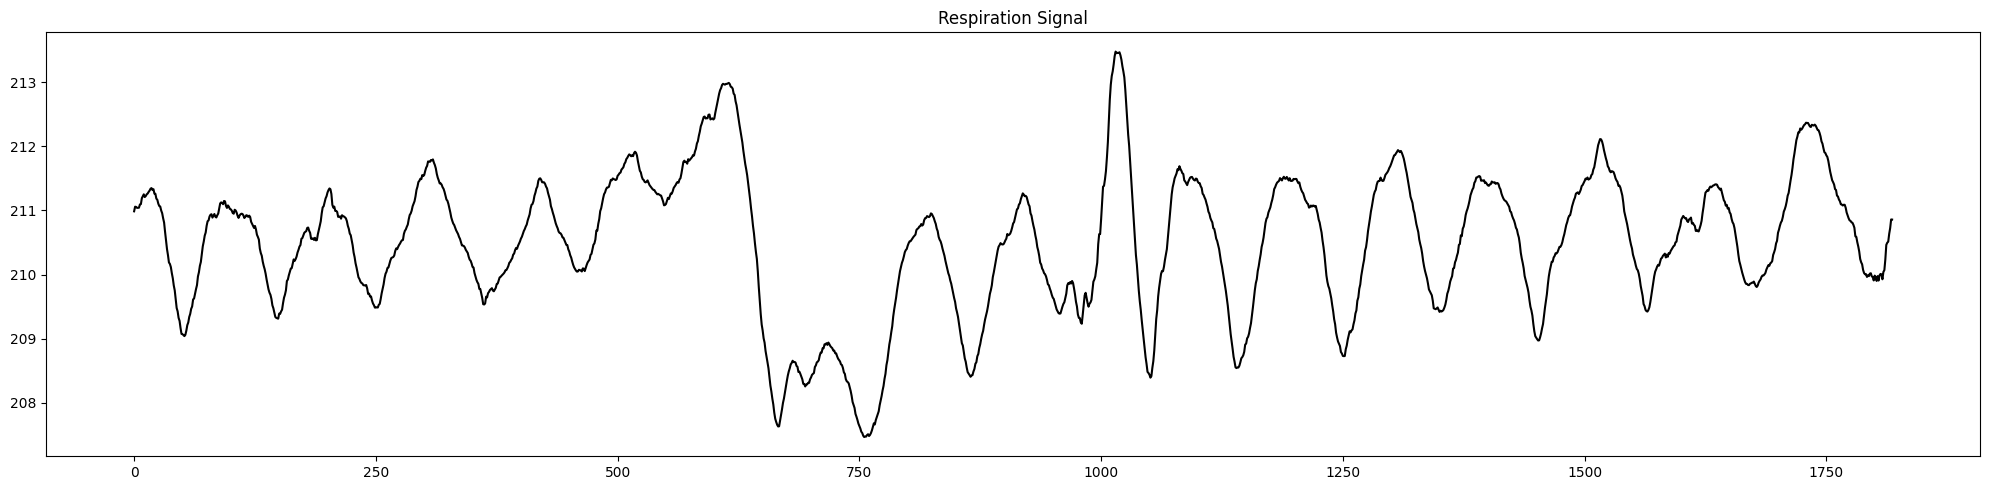

In [23]:
try:
    ## Load the Video
    file_path = os.path.join("122140055.mp4") ## Path to the video file
    
    ## Put 0 to use the camera, or use the video file path for analyzing a video
    cap = cv2.VideoCapture(file_path) 

    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    ## Untuk mendapatkan 60 detik video.
    while len(frame_buffer) < frame_buffer_limit:

        ## Read the frame from the camera
        ret, frame = cap.read() 
        if not ret:
            print("Error: Could not read frame.")
            break

        frame = cv2.resize(frame, STANDARD_SIZE)
        ## Adding the frame_buffer to the list
        frame_buffer.append(frame)

        if features is None:
            # Initialize ROI and feature detection
            initialize_features(frame)

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if len(features) > 10:
            new_features, status, error = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, features, None, **lk_params)
            good_old = features[status == 1]
            good_new = new_features[status == 1]
            mask = np.zeros_like(frame)
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                frame = cv2.circle(frame, (int(a), int(b)), 3, (0, 255, 0), -1)
            frame = cv2.add(frame, mask)
            if len(good_new) > 0:
                avg_y = np.mean(good_new[:, 1])
                resp_signal.append(avg_y)
                features = good_new.reshape(-1, 1, 2)
            old_gray = frame_gray.copy()
        else:
            # Reinitialize features if tracking fails
            initialize_features(frame)

        ## Plot bounding box
        cv2.rectangle(frame, (int(left_x), int(top_y)), (int(right_x), int(bottom_y)), (0, 255, 0), 2)
        
        # Show the frame
        cv2.imshow("frame", frame) 

        # Check if 'q' is pressed or the window is closed
        if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("frame", cv2.WND_PROP_VISIBLE) < 1:
            break

except Exception as e:
    print(f"An error occurred: {e}")
    cap.release()
    cv2.destroyAllWindows()

finally:
    ## Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()
    
    ## Plot the Respiration Signal
    plt.figure(figsize=(20, 5))
    plt.plot(resp_signal, color='black')
    plt.title('Respiration Signal')
    plt.tight_layout()
    plt.show()

# Hasil Sinyal Respirasi dengan Metode Lukas-Kanade Optical Flow

Grafik di atas menunjukan pola naik turun yang menggambarkan proses pernapasan dengan menggunakan metode Lukas-Kanade Optical flow. Setiap gelombang naik dan turun merupakan satu napas. Dengan menggunakan metode ini, kita dapat mengidentifikasi frekuensi respirasi dengan cepat dan akurat. Berdasarkan hasil observasi, didapatkan bahwa

Sinyal pernapasan menunjukkan pola osilasi yang teratur, khas dari ritme napas, namun ada beberapa ketidakteraturan, seperti puncak yang lebih tajam di sekitar angka 750. Ini mungkin menandakan napas yang lebih dalam, sedikit gerakan dari subjek, atau adanya noise pada data. Hal ini menunjukkan bahwa metode optical flow Lucas-Kanade mampu menangkap baik gerakan tipikal maupun atipikal.

Rentang amplitudo sinyal yang hanya mencapai 4 unit, dari 209 hingga 213, memperlihatkan kemampuan metode ini untuk mendeteksi gerakan yang sangat halus. Ini umum terjadi pada deteksi pernapasan berbasis video dengan optical flow, di mana sinyalnya cenderung lebih kecil dibandingkan sensor kontak langsung seperti spirometer, yang menegaskan sifat non-invasif dari pendekatan ini.

Beberapa bagian sinyal yang tampak bergerigi, terutama di rentang 1500-1750, bisa mengindikasikan adanya noise atau kesalahan kecil dalam pelacakan. Ini mungkin disebabkan oleh perubahan pencahayaan atau area dengan tekstur rendah, yang dapat mengganggu asumsi kecerahan konstan yang menjadi dasar metode Lucas-Kanade, sehingga memengaruhi akurasi estimasi gerakan.

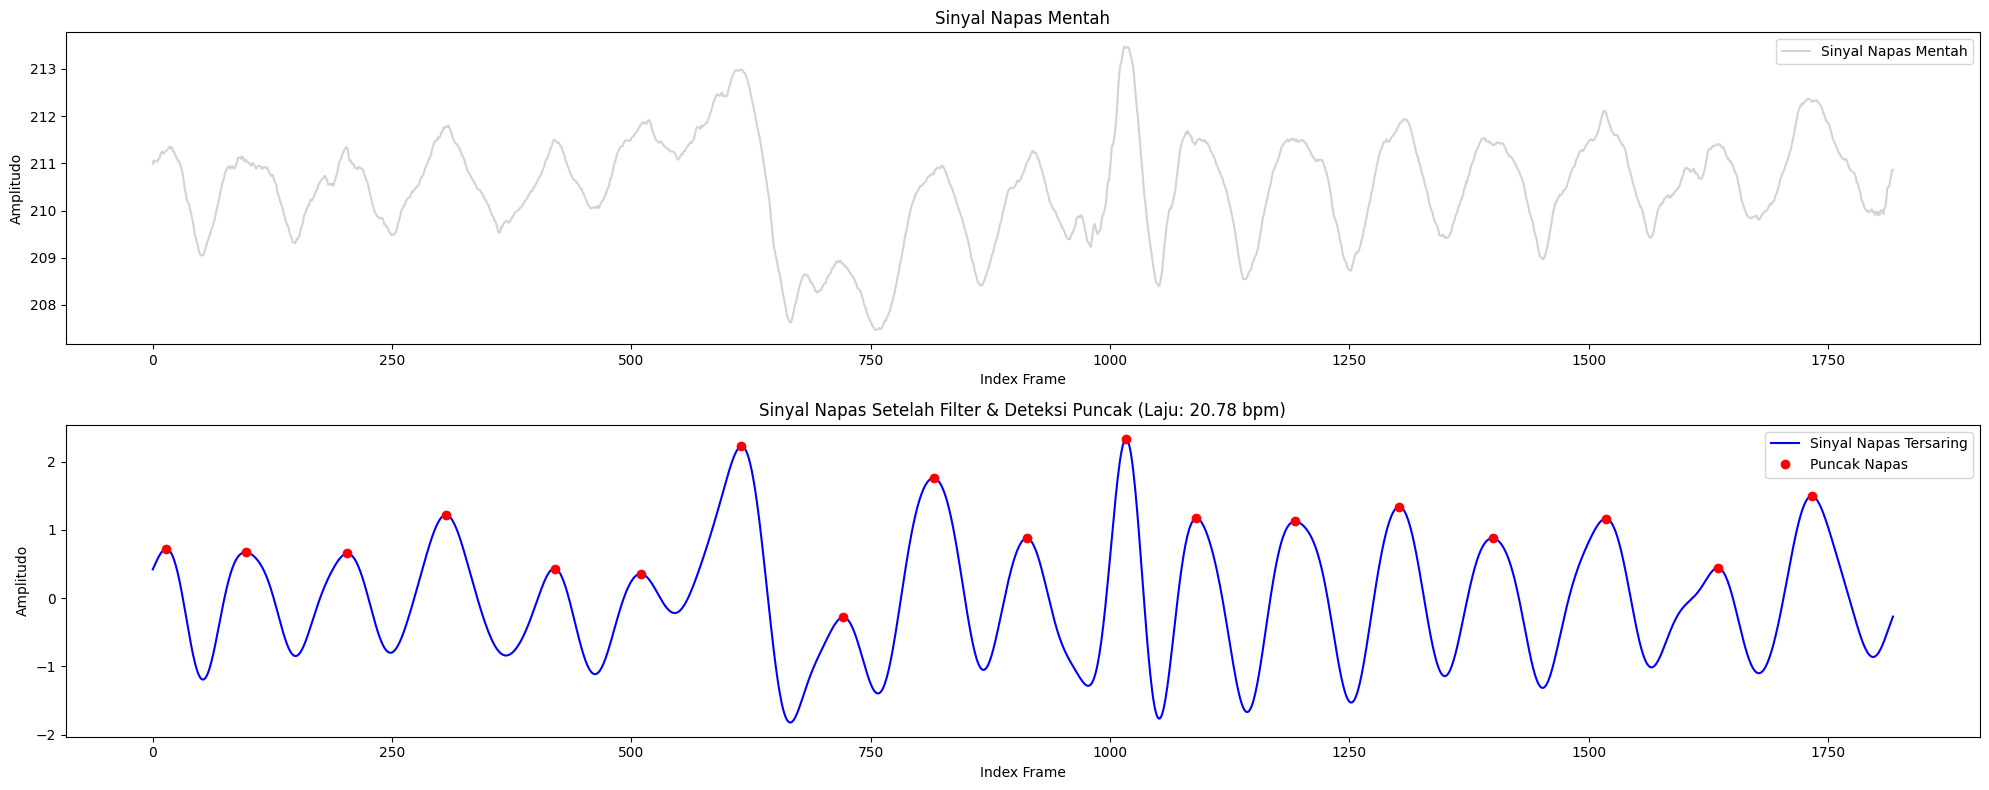

In [24]:
from scipy.signal import butter, filtfilt, find_peaks

# Parameter filter bandpass untuk mendeteksi sinyal napas (umumnya 0.1-0.7 Hz)
sampling_rate = fps  # fps sudah didefinisikan sebelumnya
freq_low = 0.1
freq_high = 0.7
filter_order = 3

# Membuat filter bandpass
b_coeff, a_coeff = butter(filter_order, [freq_low, freq_high], btype='band', fs=sampling_rate)
resp_filtered = filtfilt(b_coeff, a_coeff, resp_signal)

# Cari puncak sinyal (setiap puncak = 1 napas)
min_breath_interval = sampling_rate * 2  # minimal 2 detik antar napas
breath_peaks, _ = find_peaks(resp_filtered, distance=min_breath_interval)

# Hitung frekuensi napas (breaths per minute)
total_duration = len(resp_filtered) / sampling_rate
resp_rate_bpm = 60 * len(breath_peaks) / total_duration

# Visualisasi: subplot sinyal mentah dan hasil filter + deteksi puncak
plt.figure(figsize=(20, 8))

# Plot sinyal mentah
plt.subplot(2, 1, 1)
plt.plot(resp_signal, color='lightgray', label='Sinyal Napas Mentah')
plt.title('Sinyal Napas Mentah')
plt.xlabel('Index Frame')
plt.ylabel('Amplitudo')
plt.legend()

# Plot sinyal hasil filter dan puncak napas
plt.subplot(2, 1, 2)
plt.plot(resp_filtered, color='blue', label='Sinyal Napas Tersaring')
plt.plot(breath_peaks, resp_filtered[breath_peaks], 'ro', label='Puncak Napas')
plt.title(f'Sinyal Napas Setelah Filter & Deteksi Puncak (Laju: {resp_rate_bpm:.2f} bpm)')
plt.xlabel('Index Frame')
plt.ylabel('Amplitudo')
plt.legend()

plt.tight_layout()
plt.show()

### Perbandingan Laju Pernapasan dari Optical Flow vs Manual Stopwatch
Berdasarkan kedua plot tersebut dapat disimpulkan bahwa sinyal mentah merekam data pernapasan asli dengan sedikit noise, sedangkan sinyal yang telah difilter meningkatkan kejelasan dengan menghaluskan gelombang dan mengenali puncak untuk menghitung laju pernapasan sebesar 20,78 kali per menit.

In [25]:
# Print Laju Pernapasan
print(f"Laju Pernapasan: {resp_rate_bpm:.2f} breaths per minute")

Laju Pernapasan: 20.78 breaths per minute


In [26]:
import pandas as pd

# Load Data
df = pd.read_csv('stopwatch.csv')

# Hitung jumlah napas dari data manual (CSV)
jumlah_nafas_manual = df['Nafas ke-'].max()

# Menampilkan jumlah napas dari data manual
print(f"Jumlah napas (manual, CSV): {jumlah_nafas_manual}")

Jumlah napas (manual, CSV): 17


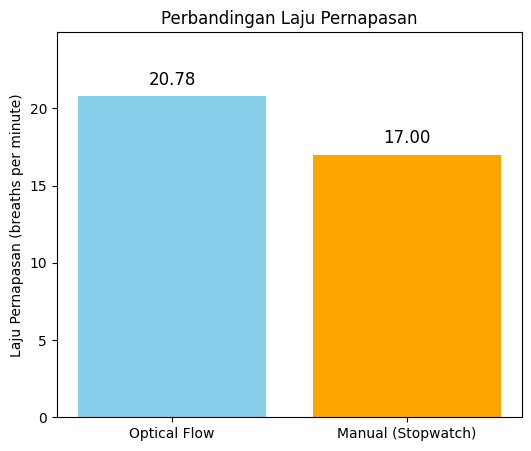

In [27]:
# Plot perbandingan laju pernapasan dari Optical Flow vs Manual Stopwatch

labels = ['Optical Flow', 'Manual (Stopwatch)']
bpm_values = [resp_rate_bpm, jumlah_nafas_manual]  # Konversi jumlah napas ke bpm

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, bpm_values, color=['skyblue', 'orange'])
plt.ylabel('Laju Pernapasan (breaths per minute)')
plt.title('Perbandingan Laju Pernapasan')
plt.ylim(0, max(bpm_values) * 1.2)

# Tambahkan nilai di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

### Perbedaan Grafik Laju Pernapasan dari Optical Flow vs Manual Stopwatch

Metode Optical Flow menunjukkan laju pernapasan sebesar 20,78 kali per menit, yang ditandai dengan batang berwarna biru.
Metode Manual (Stopwatch) menghasilkan laju pernapasan sebesar 17,00 kali per menit, yang ditandai dengan batang berwarna oranye.
Selisih antara kedua metode sekitar 3,78 kali per menit, menunjukkan bahwa Optical Flow cenderung mengukur laju pernapasan lebih tinggi dibandingkan pengukuran manual.
Perbedaan ini mungkin disebabkan oleh kepekaan Optical Flow dalam mendeteksi gerakan halus yang tidak terdeteksi secara manual, atau adanya noise dalam data otomatis yang tidak disaring sepenuhnya.

---

# Lampiran
- https://grok.com/share/bGVnYWN5_28394018-3f6c-4ba9-bfaf-c1ebee6dd8ce
- https://grok.com/share/bGVnYWN5_e6ba41b1-194d-4693-a775-1f058c2a8c37
- https://github.com/informatika-itera/if3024-handson/blob/main/2025-notebooks/7_hands-on3.ipynb
- https://github.com/informatika-itera/if3024-handson/blob/main/2025-notebooks/10_notes_h03.ipynb
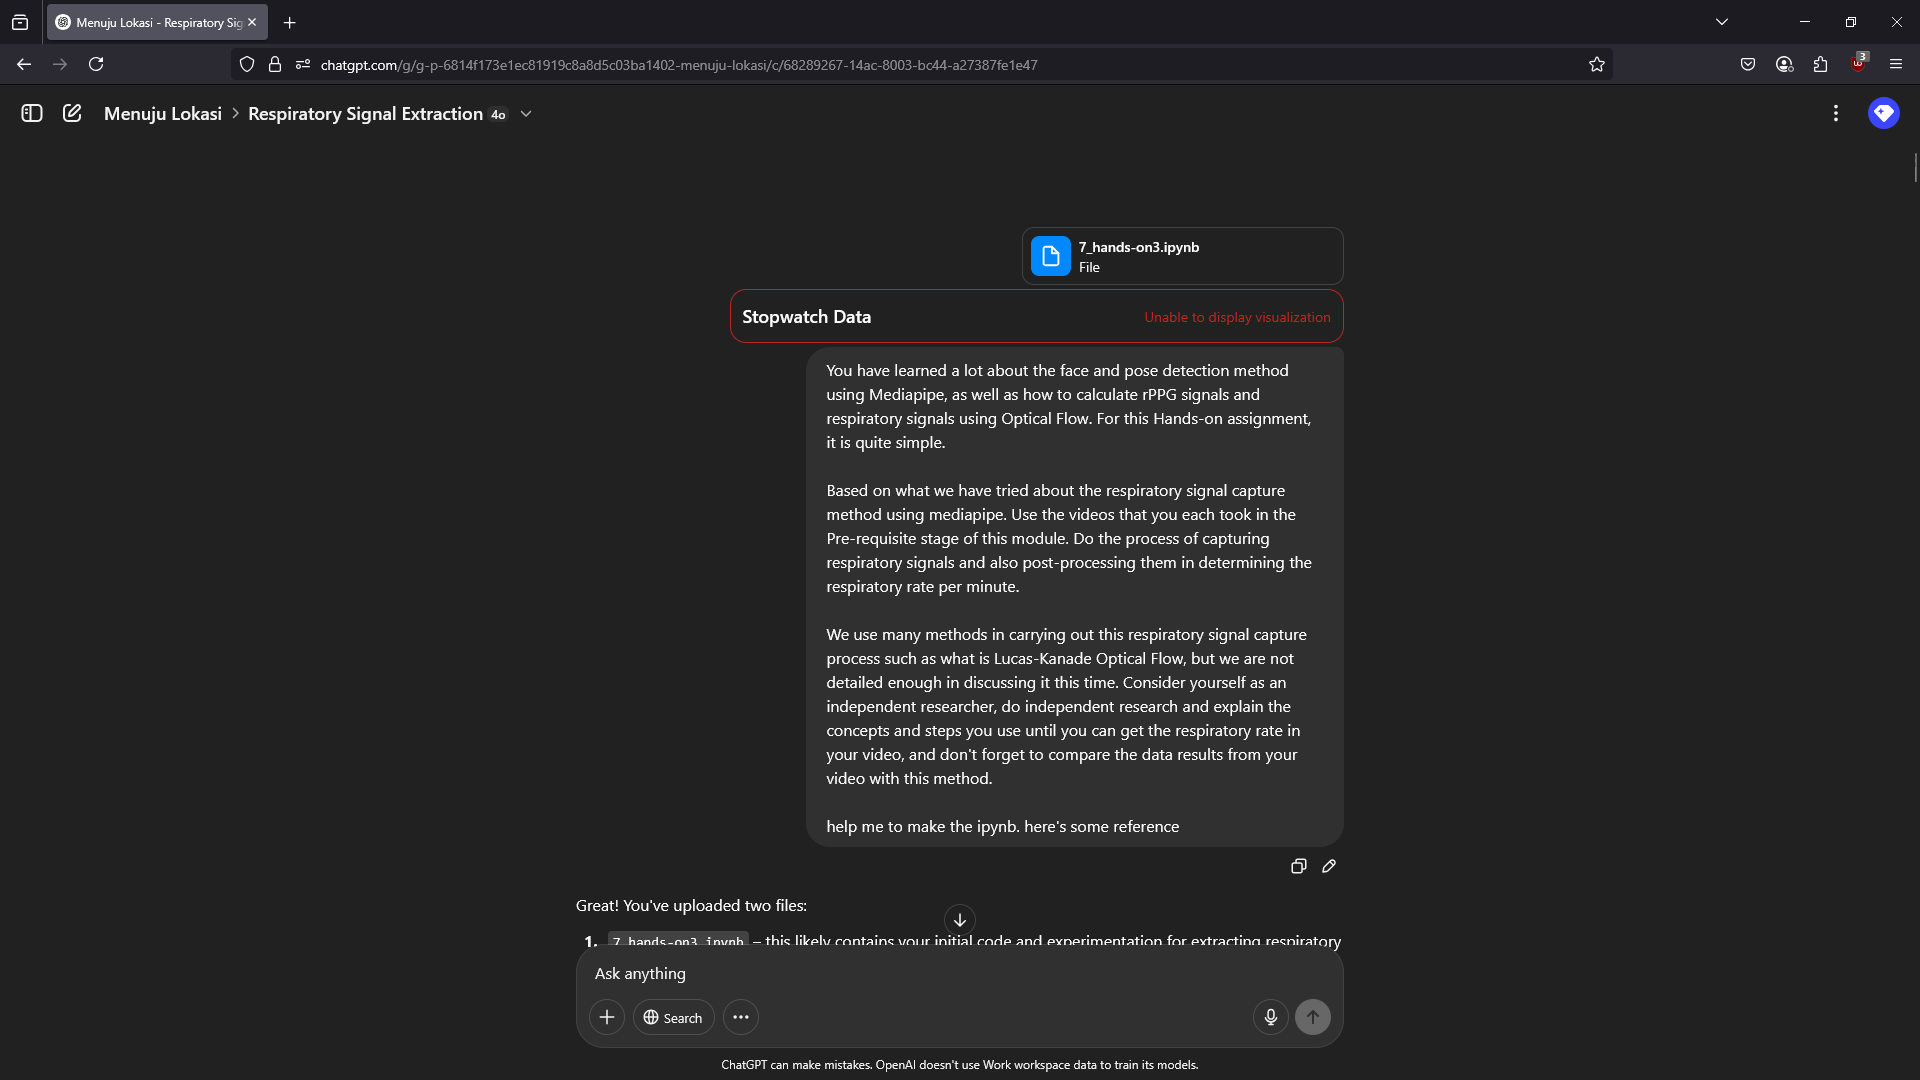
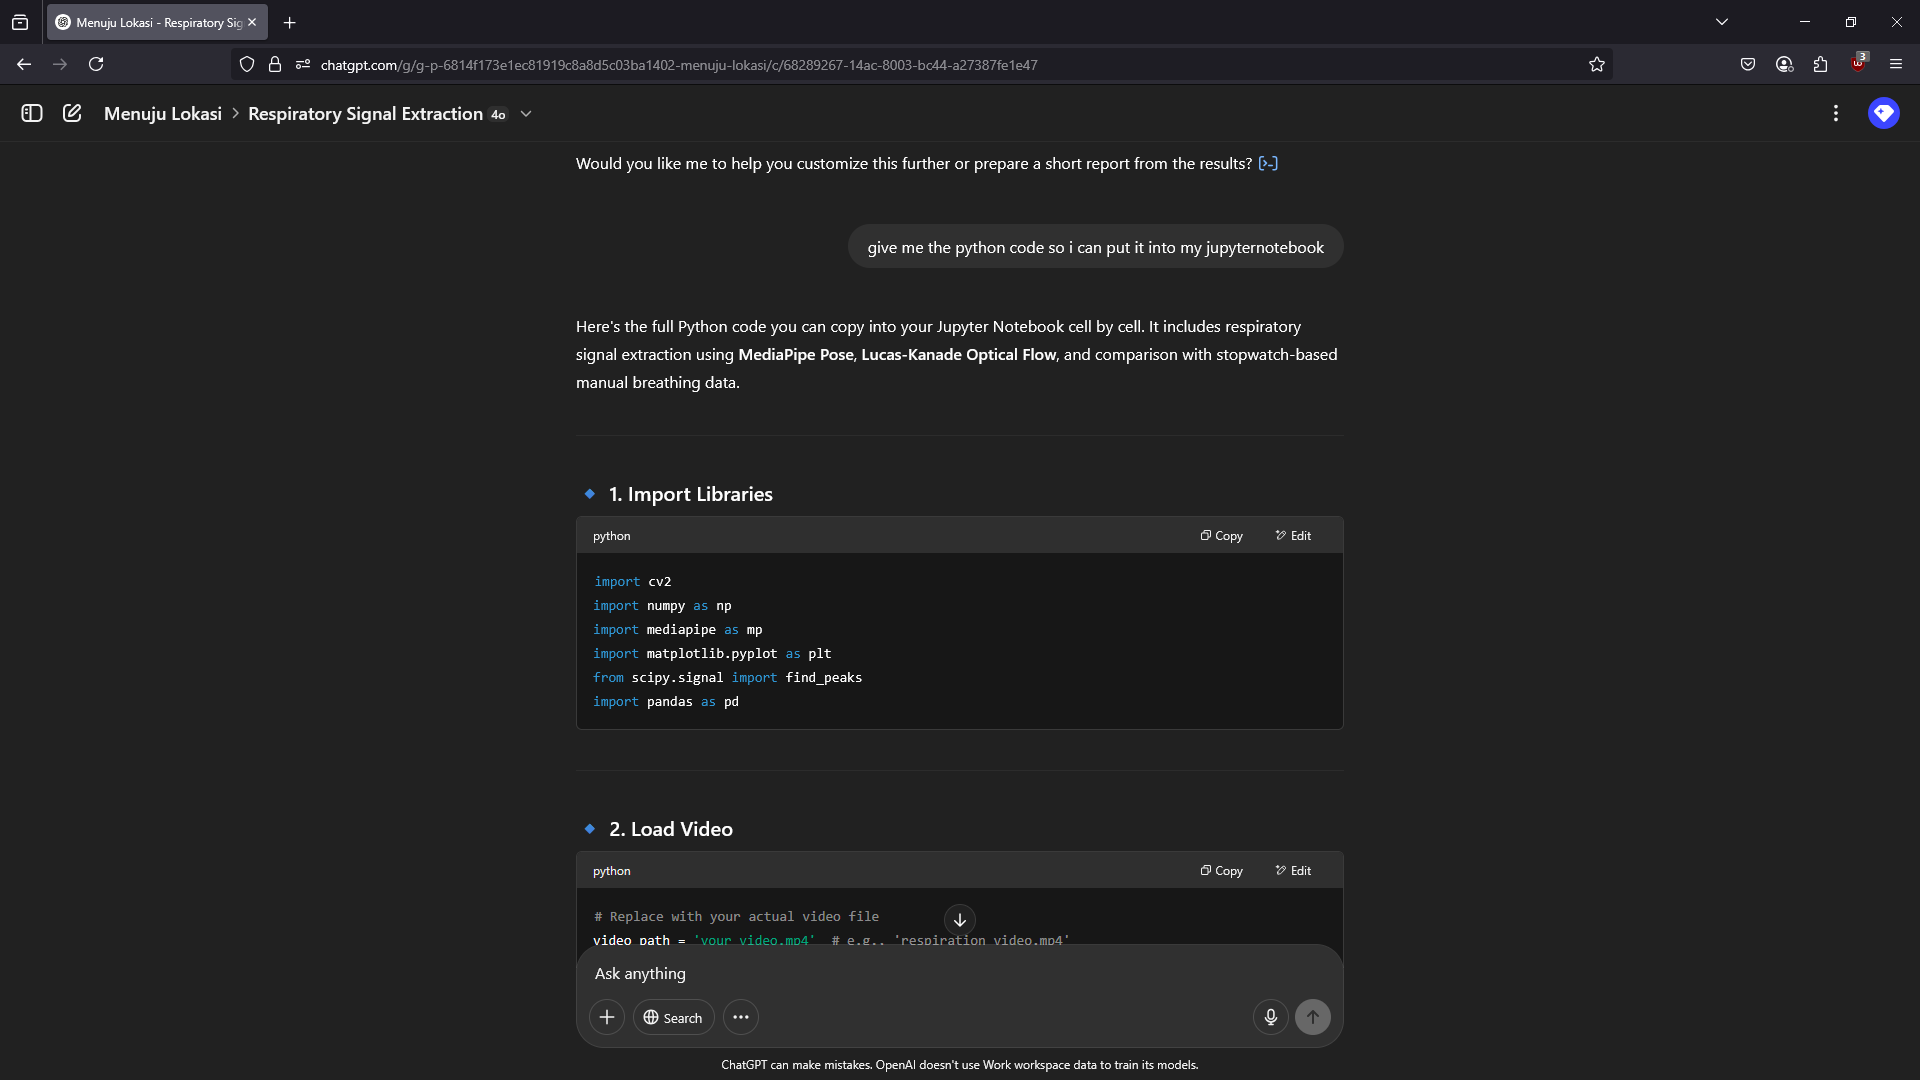
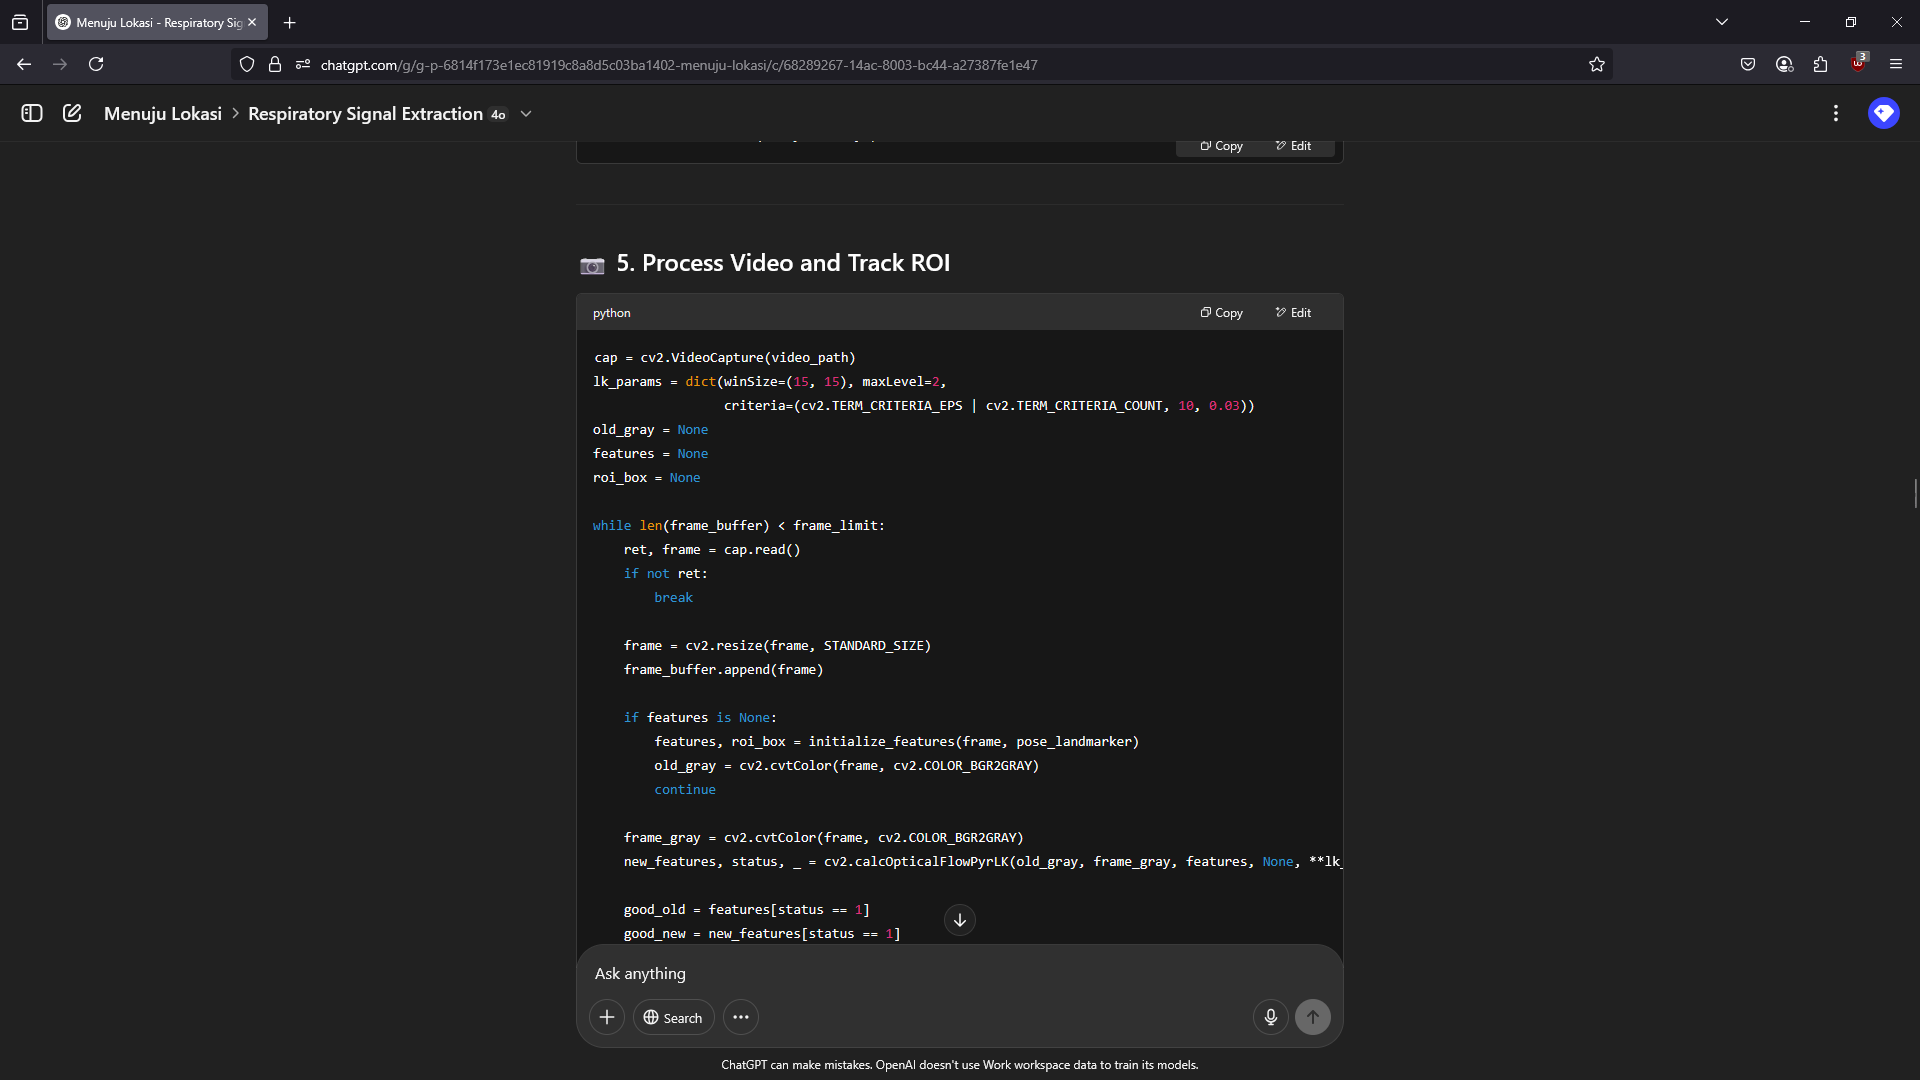
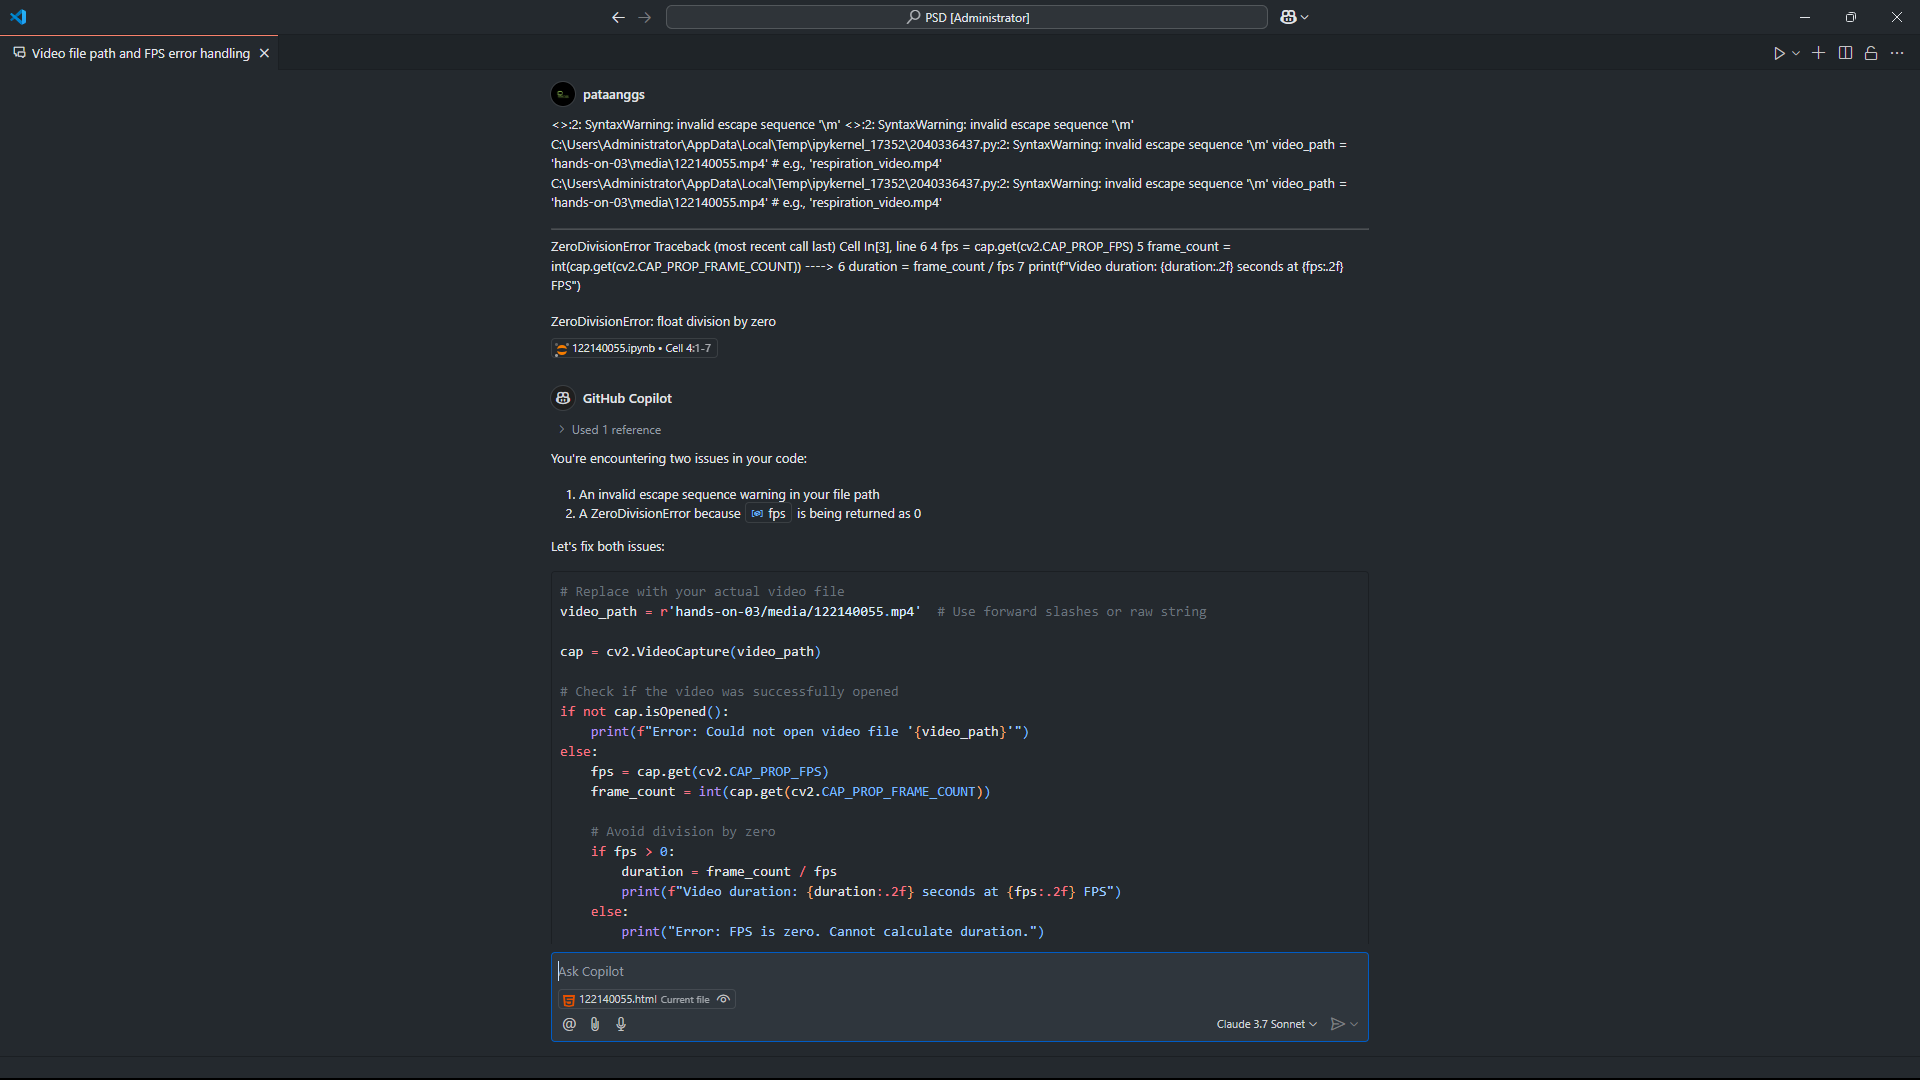
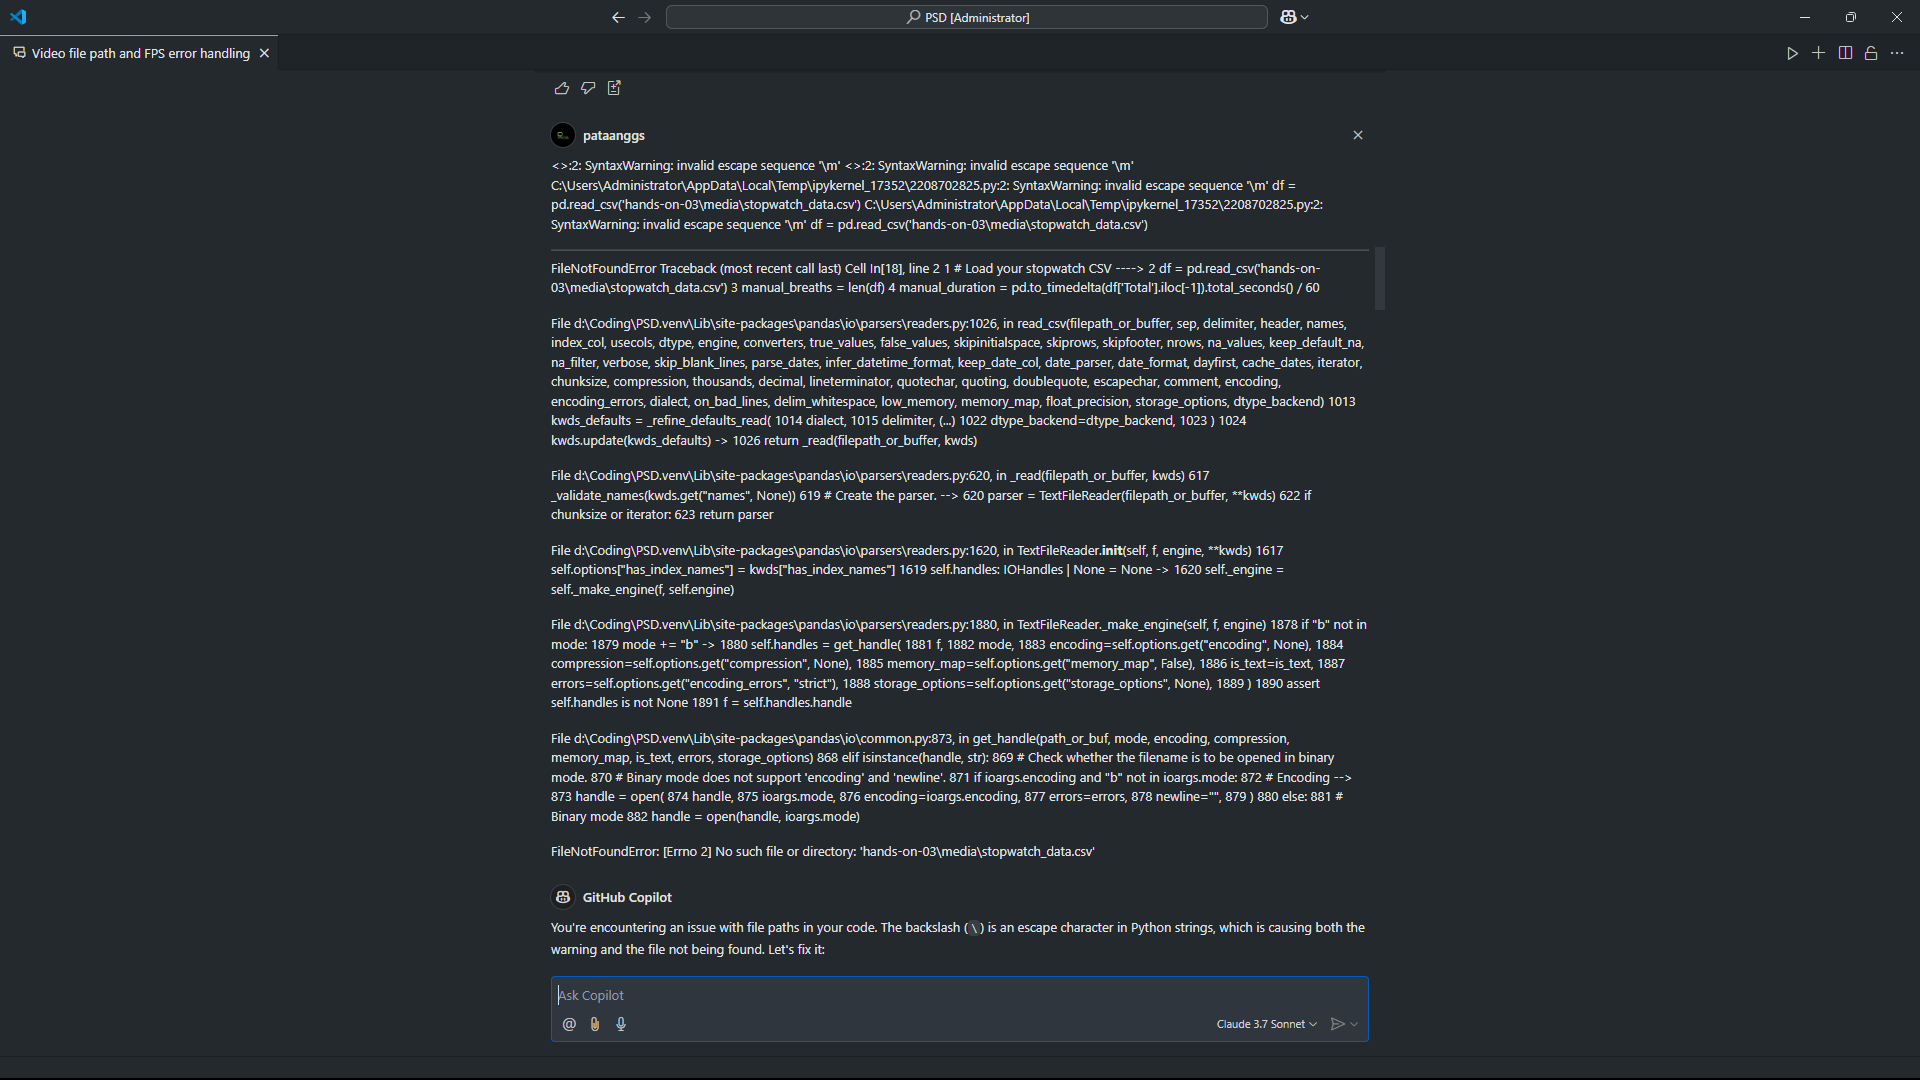
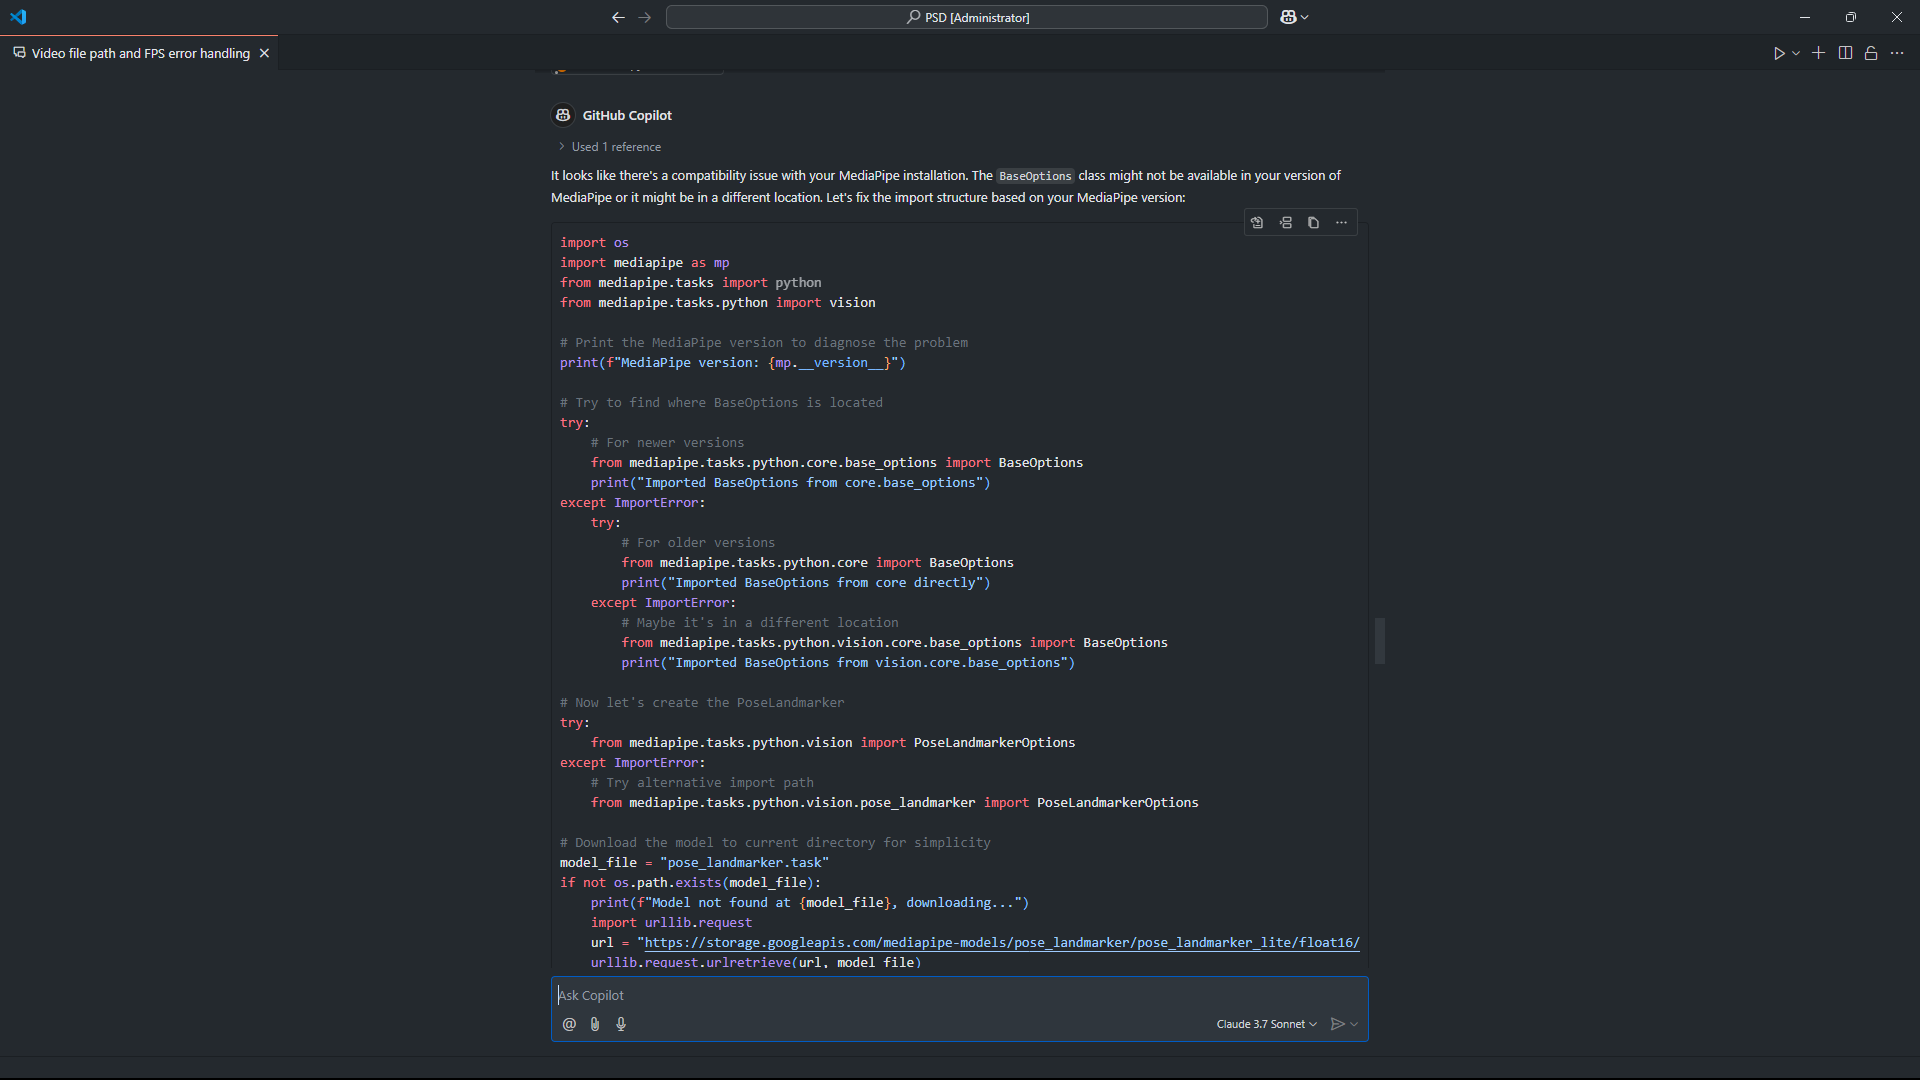